### Import Package

In [1]:
!pip install -q stockstats

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from stockstats import StockDataFrame

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from math import floor

import pandas_datareader.data as web
import pickle
import time

# Load the stock data

In [3]:
start_date = "2000-01-01"
end_date = "2022-12-31"
stock_data = web.DataReader('AAPL', 'stooq',start=start_date, end=end_date)
stock_data.columns = ["open","high","low","close","volume"]

In [4]:
# Use online package to generate additional features
x = StockDataFrame(stock_data)
data = x[['open','high','low','close','volume',
          'boll', 'boll_ub', 'boll_lb',
          'macd', 'macdh', 'macds',
          'rsi_11', 'rsi_14', 'rsi_21']]
data.index = [int(str(ind)[0:4]+str(ind)[5:7]+str(ind)[8:10]) for ind in data.index]
data = data.sort_index()

# Data Preprocessing

## Split the train and test data

In [5]:
def custom_split(data,start,end):
    train = (data.index >= start) & (data.index <= end)
    train_X = data[train]
    
    return train_X

In [6]:
train_X = custom_split(data,start = 20130101,end = 20171031)
valid_X = custom_split(data,start = 20171101,end = 20181231)
test_X = custom_split(data,start = 20190101,end = 20201231)

## Label the target result (opening price on 6th day)

In [7]:
# Assume we use 6 days price data to predict closing price of the 6th day
num_day_to_predict = 5


In [8]:
def produce_result_target_price(X,num_day,result_col_name = "result_price"):
    y = pd.DataFrame(np.nan, index=X.index, columns=[result_col_name])
    for i in range(num_day,len(X)):
        y.loc[X.index[i-1],result_col_name] = X.loc[X.index[i],"open"]
    
    return y

In [9]:
train_y = produce_result_target_price(train_X,num_day_to_predict)
valid_y = produce_result_target_price(valid_X,num_day_to_predict)
test_y = produce_result_target_price(test_X,num_day_to_predict)

## Transform the X-day data into one vector

In [10]:
def transform_x_data_to_one_vector(X,num_day):
    col_name = []
    for i in range(num_day):
        for j in X.columns:
            col_name.append(j+"-"+str(i))
    new_X = pd.DataFrame(np.nan, index=X.index, columns=col_name)
    
    for i in range(num_day-1,len(X)):
        for col in col_name:
            split_list = col.split("-")
            new_X.loc[X.index[i],col] = X.loc[X.index[i-int(split_list[1])],split_list[0]]
    
    return new_X

In [11]:
train_X_5 = transform_x_data_to_one_vector(train_X,num_day_to_predict)
valid_X_5 = transform_x_data_to_one_vector(valid_X,num_day_to_predict)
test_X_5 = transform_x_data_to_one_vector(test_X,num_day_to_predict)

## Drop out rows with NaN

In [12]:
def drop_nan_row_y(y,num_day):
    drop_list = [y.index[i] for i in range(num_day)]
    drop_list.append(y.index[-1])
    return y.drop(drop_list)

def drop_nan_row_X(X,num_day):
    drop_list = [X.index[i] for i in range(num_day)]
    drop_list.append(X.index[-1])
    return X.drop(drop_list)

In [13]:
new_train_X_5 = drop_nan_row_X(train_X_5,num_day_to_predict)
new_train_y = drop_nan_row_y(train_y,num_day_to_predict)

new_valid_X_5  = drop_nan_row_X(valid_X_5,num_day_to_predict)
new_valid_y = drop_nan_row_y(valid_y,num_day_to_predict)

new_test_X_5  = drop_nan_row_X(test_X_5,num_day_to_predict)
new_test_y = drop_nan_row_y(test_y,num_day_to_predict)




In [14]:
# Keep a copy for reverting prediction result
old_train_X_5 = new_train_X_5
old_train_y = new_train_y
old_valid_X_5 = new_valid_X_5
old_valid_y = new_valid_y
old_test_X_5 = new_test_X_5
old_test_y = new_test_y

## Normalize data row by row

In [15]:
def normalize_data_by_row(X,y):
    norm_X = X.sub(X.mean(axis=0), axis=1).div(X.std(axis=0), axis=1)
    
    col_list =[] 
    for col in X.columns:
        if "open" in col:
            col_list.append(col)
    
    temp_y = y.loc[:,"result_price"]
    mean = np.mean(X.loc[:,col_list],axis=1)
    mean.index = temp_y.index
    std = np.std(X.loc[:,col_list],axis=1)
    std.index = temp_y.index

    norm_y = pd.DataFrame((temp_y-mean)/std,
                          columns=["result_price"])
                         
    return (norm_X,norm_y)

In [16]:
new_train_X_5,new_train_y = normalize_data_by_row(new_train_X_5,new_train_y)
new_valid_X_5,new_valid_y = normalize_data_by_row(new_valid_X_5,new_valid_y)
new_test_X_5,new_test_y = normalize_data_by_row(new_test_X_5,new_test_y)

# Model Training and Fitting

In [ ]:
new_train_X_5,new_train_y 
new_valid_X_5,new_valid_y 
new_test_X_5,new_test_y

In [17]:
svr = SVR()

In [28]:
from sklearn.model_selection import GridSearchCV
params_ = {'kernel' : ('poly', 'rbf', 'sigmoid'),'C' : [i*100 for i in range(24,31)],
           'coef0' : [0.00001,0.0001,0.0005,0.01,0.05,0.5],
           'gamma' : ('auto','scale')},
grid_search = GridSearchCV(estimator = svr, param_grid = params_, cv = 5, n_jobs = -1, verbose = 2)

In [29]:
grid_search

GridSearchCV(cv=5, estimator=SVR(C=5, coef0=0.01, gamma='auto'), n_jobs=-1,
             param_grid=({'C': [2400, 2500, 2600, 2700, 2800, 2900, 3000],
                          'coef0': [1e-05, 0.0001, 0.0005, 0.01, 0.05, 0.5],
                          'gamma': ('auto', 'scale'),
                          'kernel': ('poly', 'rbf', 'sigmoid')},),
             verbose=2)

In [30]:
grid_search.fit(new_train_X_5,new_train_y)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


KeyboardInterrupt: ignored

In [22]:
grid_search.best_params_

{'C': 5, 'coef0': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}

In [24]:
svr = SVR(**grid_search.best_params_)
svr.fit(new_train_X_5, new_train_y)

svr_prediction = svr.predict(new_test_X_5)
svr_confidence = svr.score(new_test_X_5, new_test_y)
print("svr confidence:", svr_confidence)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence: 0.31542848033694215


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 1000 ): 0.5273115998252391


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 1100 ): 0.5296289229309408


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 1200 ): 0.5309145772762206


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 1300 ): 0.5339637142993023


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 1400 ): 0.536422566305625


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 1500 ): 0.5375152893411048


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 1600 ): 0.538687914950578


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 1700 ): 0.5397810497470155


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 1800 ): 0.5406723224925103


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 1900 ): 0.5410135918816492


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 2000 ): 0.5418652045592668


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 2100 ): 0.5424126390693726


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 2200 ): 0.54277157541355


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 2300 ): 0.5431140137671742


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 2400 ): 0.5431388478220789


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 2500 ): 0.5433265645477526


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 2600 ): 0.5441617057951329


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 2700 ): 0.5445714144339082


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 2800 ): 0.5443446035600739


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 2900 ): 0.5436215565475018


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (c = 3000 ): 0.5435220238712705


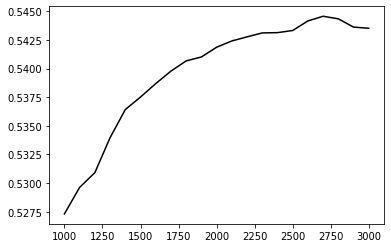

In [ ]:
# Use Support Vector Regressor to fit the data

# C : Regularization parameter. The strength of the regularization is inversely proportional to C.
c_list = [i*100 for i in range(10,31)]
svr_conf_list = []
for c in c_list:
    # gamma : Kernel coefficient
    gamma = 0.00001

    # radial basis function kernel
    kernel="rbf"

    svr = SVR(kernel=kernel, C=c, gamma=gamma)
    svr.fit(new_train_X_5, new_train_y)

    svr_prediction = svr.predict(new_valid_X_5)
    svr_confidence = svr.score(new_valid_X_5, new_valid_y)
    print("svr confidence (c =", c,"):", svr_confidence)
    svr_conf_list.append(svr_confidence)
    
plt.plot(c_list, svr_conf_list, label = "C to SVR Confid", color = 'Black')

In [ ]:
# Choose C = 2500

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (gamma = 1e-07 ): 0.2924503810871598


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (gamma = 5e-07 ): 0.43292358279944054


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (gamma = 1e-06 ): 0.473450010168735


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (gamma = 5e-06 ): 0.5318009855995516


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (gamma = 1e-05 ): 0.5433265645477526


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (gamma = 5e-05 ): 0.3403650983488413


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (gamma = 0.0001 ): -0.08024197734020788


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence (gamma = 0.0005 ): -1.8881537635373808


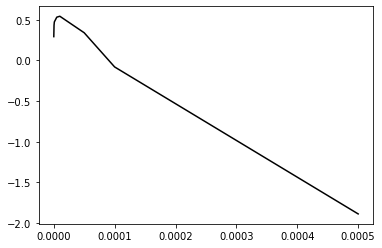

In [ ]:
# Use Support Vector Regressor to fit the data

# gamma : Kernel coefficient

gamma_list = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005]
svr_conf_list = []
for gamma in gamma_list:
    # C : Regularization parameter. The strength of the regularization is inversely proportional to C.
    c = 2500

    # radial basis function kernel
    kernel="rbf"

    svr = SVR(kernel=kernel, C=c, gamma=gamma)
    svr.fit(new_train_X_10, new_train_y)

    svr_prediction = svr.predict(new_valid_X_10)
    svr_confidence = svr.score(new_valid_X_10, new_valid_y)
    print("svr confidence (gamma =", gamma,"):", svr_confidence)
    svr_conf_list.append(svr_confidence)
    
plt.plot(gamma_list, svr_conf_list, label = "gamma to SVR Confid", color = 'Black')

In [ ]:
# Choose gamma = 0.00001

# Model Testing

In [ ]:
# C : Regularization parameter. The strength of the regularization is inversely proportional to C.
c = 2500

# gamma : Kernel coefficient
gamma = 0.00001

# radial basis function kernel
kernel="rbf"

svr = SVR(kernel=kernel, C=c, gamma=gamma)
svr.fit(new_train_X_5, new_train_y)

svr_prediction = svr.predict(new_test_X_5)
svr_confidence = svr.score(new_test_X_5, new_test_y)
print("svr confidence:", svr_confidence)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


svr confidence: 0.4010474438506175


# Model Export

In [ ]:
with open("model/svr_"+str(num_day_to_predict)+"day.pickle", "wb") as f:
    pickle.dump(svr, f)